Anne Urai, CSHL, 2019

code for https://www.abstractsonline.com/pp8/#!/7883/presentation/46202

see also Reinagel et al. Frontiers for effects of CA water in rats.

In [1]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath = 'figures' # put in the same folder, but add to .gitignore for now

Connecting anneurai@datajoint.internationalbrainlab.org:3306


# STUDY 1. effects of CA on water intake and weight
data collected by Ines Laranjeira and Fanny Cazettes, CCU

In [2]:
########### SUBJECTS ########### 

subj = subject.Subject * subject.SubjectLab * subject.SubjectProject & 'subject_project = "collab_citricacid"' & 'lab_name="mainenlab"'

########### WEIGHINGS ########### 

weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date < "2018-10-24"'
baseline_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date = "2018-09-24"'

avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)') 
avg_baseline_weight_date = baseline_date.aggr(weight_with_date, avg_weight = 'AVG(weight)')

b = subj * avg_weight_date 
bb = subj * avg_baseline_weight_date

weight_df = pd.DataFrame(b.fetch(as_dict=True))
#weight_df.tail(n=10)

baseline_df = pd.DataFrame(bb.fetch(as_dict=True))
#baseline_df.tail(n=10)

In [3]:
########### WEIGHINGS NORMALIZATION and ########### 
########### CONVERSION OF SESSION DATES INTO SESSION NUMBERS ########### 

baseline_date = datetime.toordinal(datetime(2018, 9, 24))
change_date = datetime.toordinal(datetime(2018, 10, 5)) 

# Citric acid 2% was given on the 4th of Oct but on that day there was a 5-min 
# free water session, so I the 5th of Oct is used, as it is more accurate to show the effect of the change in concentration

normalized_df = weight_df.copy()
subject_count = 0
for s in baseline_df['subject_uuid']:
    subject_count += 1
    entry = normalized_df['subject_uuid'] == s # outputs list of booleans - True for all entries of mouse s 
    
    weight_count = 0
    for d in entry:
        weight_count += 1
        if d == True:
            normalized_df['avg_weight'][weight_count-1] = normalized_df['avg_weight'][weight_count-1] / baseline_df['avg_weight'][subject_count-1]
            normalized_df['session_date'][weight_count-1]  = datetime.toordinal(normalized_df['session_date'][weight_count-1]) - baseline_date
            

########### CONDITIONS ########### 

# CTL = free water regime (control)
# CA = ad libitum citric acid water
# FA = fixed amount of water per day (600 uL per weekday and 1 mL per weekend)
# CA = calculated amount (40 uL/g/day)

# now, we want to map these onto the subject names
CTL = 'Free water'
CA = 'Citric Acid'
WD = 'Weight-based amount'
FA = 'Fixed amount'

condition_map = {'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL, 
'6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
'ZM_202':FA, 'ZM_337':FA, 'ZM_206':FA, 'ZM_208':FA, 
'ZM_203':WD, 'ZM_210':WD, 'ZM_338':WD, '6870':WD}

normalized_df['condition'] = normalized_df.subject_nickname.map(condition_map)
#normalized_df.tail(n=10)
#weight_df['condition'] = weight_df.subject_nickname.map(condition_map)

/anaconda3/envs/djenv/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/envs/djenv/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


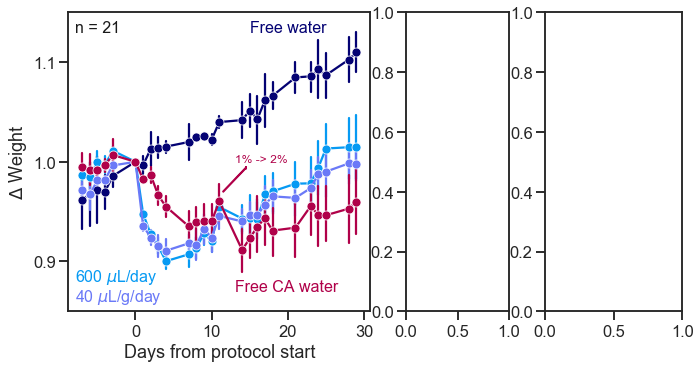

In [7]:
########### PLOTS ########### 
palette = sns.xkcd_palette(['deep blue', 'azure', 'cornflower', 'raspberry'])
hue_order = ['Free water', 'Fixed amount', 'Weight-based amount', 'Citric Acid']

f, ax = plt.subplots(ncols=3, nrows=1, gridspec_kw=dict(width_ratios=[2.2, 0.75, 1]), figsize=(11, 5.5))
    
sns.lineplot(x="session_date", y="avg_weight", err_style='bars', 
             ci=68, hue="condition", marker='o', data=normalized_df, ax=ax[0], legend=False, 
            palette=palette, hue_order=hue_order)
ax[0].set_xlabel("Days from protocol start")    
ax[0].set_ylabel("$\Delta$ Weight")         
ax[0].set(ylim=[0.85, 1.15], yticks=[0.9, 1, 1.1])
ax[0].text(15, 1.13,'Free water', {'color':palette[0], 'fontsize':16})
ax[0].text(-8, 0.88,'600 $\mu$L/day', {'color':palette[1], 'fontsize':16})
ax[0].text(-8, 0.86,'40 $\mu$L/g/day', {'color':palette[2], 'fontsize':16})
ax[0].text(13, 0.87,'Free CA water', {'color':palette[3], 'fontsize':16})
ax[0].text(13, 1,'1% -> 2%', {'color':palette[3], 'fontsize':12})
ax[0].text(-8, 1.13, 'n = 21', {'color':'k', 'fontsize':16})
ax[0].arrow(11.5, 0.97, 3, 0.024, color=palette[3])


In [8]:
########### WATER ADMINISTRATIONS ########### 
water_with_date = (action.WaterAdministration & subj).proj('watertype_name', 'water_administered', 'adlib', # it can restrict on the subj here but it will anyway do later
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date) & 'session_date < "2018-10-24"'& 'session_date > "2018-10-05"'
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
b = subj * total_water_date # including water will exclude mice with ad lib water
df = pd.DataFrame(b.fetch(as_dict=True))

########### CONDITIONS ########### 

# CTL = free water regime (control)
# CA = ad libitum citric acid water
# FA = fixed amount of water per day (600 uL per weekday and 1 mL per weekend)
# CA = calculated amount (40 uL/g/day)

CA = 'Citric Acid'
WD = 'Weight-based amount'
FA = 'Fixed amount'
CTL = 'Free water'

condition_map = {'6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
'ZM_202':FA, 'ZM_337':FA, 'ZM_206':FA, 'ZM_208':FA, 
'ZM_203':WD, 'ZM_210':WD, 'ZM_338':WD, '6870':WD,
'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL}

df['condition'] = df.subject_nickname.map(condition_map)

########### PLOTS ########### 
sns.swarmplot(x="condition", y="total_water", order=['Free water', 'Citric Acid'],  
              data=df, palette = sns.xkcd_palette(['deep blue', 'raspberry']), ax=ax[1])
sns.boxplot(x="condition", y="total_water", order=[ 'Free water', 'Citric Acid'], data=df, 
            fliersize=0, boxprops={'facecolor':'None'}, width=.3, ax=ax[1])
ax[1].set(ylabel='Water drank in home cage (mL/day)', xlabel='')
ax[1].set_xticklabels(['', ''])


[Text(0.0, 0, ''), Text(0.5, 0, '')]

In [9]:
########### WATER ########### 
water= pd.read_csv('thirst.csv') # first date is exclude (habituation)

# MAP MICE ONTO DIFFERENT CONDITIONS
CA = 'Citric Acid'
WD = 'Weight-based amount'
FA = 'Fixed amount'
CTL = 'Free water'

condition_map = {'6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
'ZM_202':FA, 'ZM_337':FA, 'ZM_206':FA, 'ZM_208':FA, 
'ZM_203':WD, 'ZM_210':WD, 'ZM_338':WD, '6870':WD,
'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL}

water['condition'] = water.subject.map(condition_map)

########### PLOTTING ########### 
sns.swarmplot(x="condition", y="water_amount", order=hue_order,  
              data=water, ax=ax[2], palette=palette)
sns.boxplot(x="condition", y="water_amount", order=hue_order, 
            data=water, fliersize=0, boxprops={'facecolor':'None'}, width=.3, ax=ax[2])
ax[2].set(ylabel='Water drank in 5 minutes (mL)', xlabel='')
ax[2].set_xticklabels(['', ''])

f.tight_layout()
f.savefig(os.path.join(figpath, "citricacid_study1.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study1.png"), dpi=600)

# STUDY 2. effects of CA on task performance
data collected by Valeria Aguillon and Anne Urai, CSHL

In [70]:
# FIND THE DATA WE NEED
subj = (subject.Subject() & 'subject_birth_date < "2018-09-01"').proj('subject_nickname', 'sex') * \
    (subject.SubjectLab() & 'lab_name="churchlandlab"').proj()
print(subj)

# get date for each weighing
weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')

# NOW DO THE SAME FOR WATER
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
# total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
#                                    watertype="CONCAT_WS('; ', watertype_name)")
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
# get session with date
session_with_date = behavior.TrialSet.proj('n_trials') \
    * (acquisition.Session.proj(session_date='DATE(session_start_time)') & 'session_date > "2019-03-17"') \
    * behavioral_analyses.PsychResults()
b = subj * session_with_date * avg_weight_date * total_water_date
df = pd.DataFrame(b.fetch(as_dict=True))
#df.tail(n=10)

# ADD SOME MORE USEFUL INFO - group by week, from Saturday to Friday
df['session_date'] = pd.to_datetime(df.session_date)
df['week_number']  = df['session_date'].dt.week
df['weekday_name'] = df['session_date'].dt.day_name()
df['weekday']      = df['session_date'].dt.weekday

# THEN GIVE EVERY WEEK A CONDITION NAME!
#
# let's define 5 conditions
# O = one mL water in weekend, sucrose water in task
# C = citric acid water in weekend, sucrose water in task
# CC = citric acid water in weekend + week, sucrose water in task
# W = regular water in weekend, sucrose water in task
# WW = regular water in weekend + week, sucrose water in task
#
# now, we want to map these onto the week numbers
condition_map = {10:'CC', 11:'C', 12:'C', 13:'C', 14:'C', 15:'C', 16:'C', 
                 17:'CC', 18:'C', 19:'WW', 20:'O', 21:'C', 22:'C', 23:'C', 24:'C', 25:'WW',
                27:'CC', 28:'WW', 29:'O', 30:'CC', 31:'W', 32:'O', 33:'W', 34:'W', 36:'H', 37:'H', 38:'C', 39:'H'}

df['condition'] = df.week_number.map(condition_map)

# SHOW THIS, AND CHECK THAT IT'S CORRECT!
# sanitycheck = df.groupby(['week_number', 'condition', 'session_date', 'weekday_name'])['watertype'].unique()
# sanitycheck.to_csv(os.path.join(figpath, "check_water_conditions.csv"))

# redo the color mapping
condition_order = ["WW", "W", "O", "C", "H", "CC"]
palette = sns.xkcd_palette(['deep blue', 'electric blue', 'azure', 'purpley pink', 'dark lilac', 'raspberry'])
df.describe()

*subject_uuid  subject_nickna sex    
+------------+ +------------+ +-----+
034c07c5-69b0- IBL_25         M      
063bc242-80a7- IBL_16         M      
1208c089-8b8e- IBL_13         M      
1fce4668-e99f- IBL_36         M      
24ccb0ca-c7cb- IBL_17         M      
278bf922-073e- IBL_26         M      
34d5b181-e7c8- IBL_45         M      
3e97e1d3-2a0f- IBL_34         M      
3f854f88-7879- IBL_11         M      
50883573-cf52- IBL_47         M      
52a800fc-cbbc- IBL_1          M      
55381f61-4e47- IBL_46         M      
   ...
 (Total: 22)



,n_trials,performance,performance_easy,threshold,bias,lapse_low,lapse_high,avg_weight,total_water,adlib,week_number,weekday
count,710.000000,710.000000,710.000000,710.000000,710.000000,7.100000e+02,7.100000e+02,710.000000,710.000000,710.000000,710.000000,710.000000
mean,594.053521,0.804119,0.949897,15.308799,2.268334,2.454024e-02,7.446752e-02,26.145503,1.482705,0.287324,24.554930,1.985915
std,270.963922,0.121168,0.090513,12.240387,10.405311,4.117467e-02,1.315669e-01,2.273240,0.714375,0.452833,7.892021,1.382879
min,46.000000,0.147390,0.250000,0.000021,-86.105900,7.504900e-15,4.272760e-14,21.410000,0.027000,0.000000,12.000000,0.000000
25%,426.000000,0.778605,0.953177,9.023117,-0.693380,6.575622e-08,7.494410e-03,24.299999,1.056750,0.000000,18.000000,1.000000
50%,605.500000,0.837834,0.983098,11.538450,0.776453,1.067740e-02,2.592885e-02,26.150000,1.506000,0.000000,24.000000,2.000000
75%,762.250000,0.882941,0.993836,17.513575,3.331615,3.031500e-02,7.413143e-02,27.450001,1.928250,1.000000,31.000000,3.000000
max,1581.000000,0.942976,1.000000,100.000000,100.000000,3.084300e-01,1.000000e+00,32.389999,3.705000,1.000000,39.000000,4.000000


In [71]:
# MAKE NICE-LOOKING DATE AXES
import matplotlib.dates as mdates
def fix_date_axis(ax):
    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    for item in ax.get_xticklabels():
        item.set_rotation(-90)

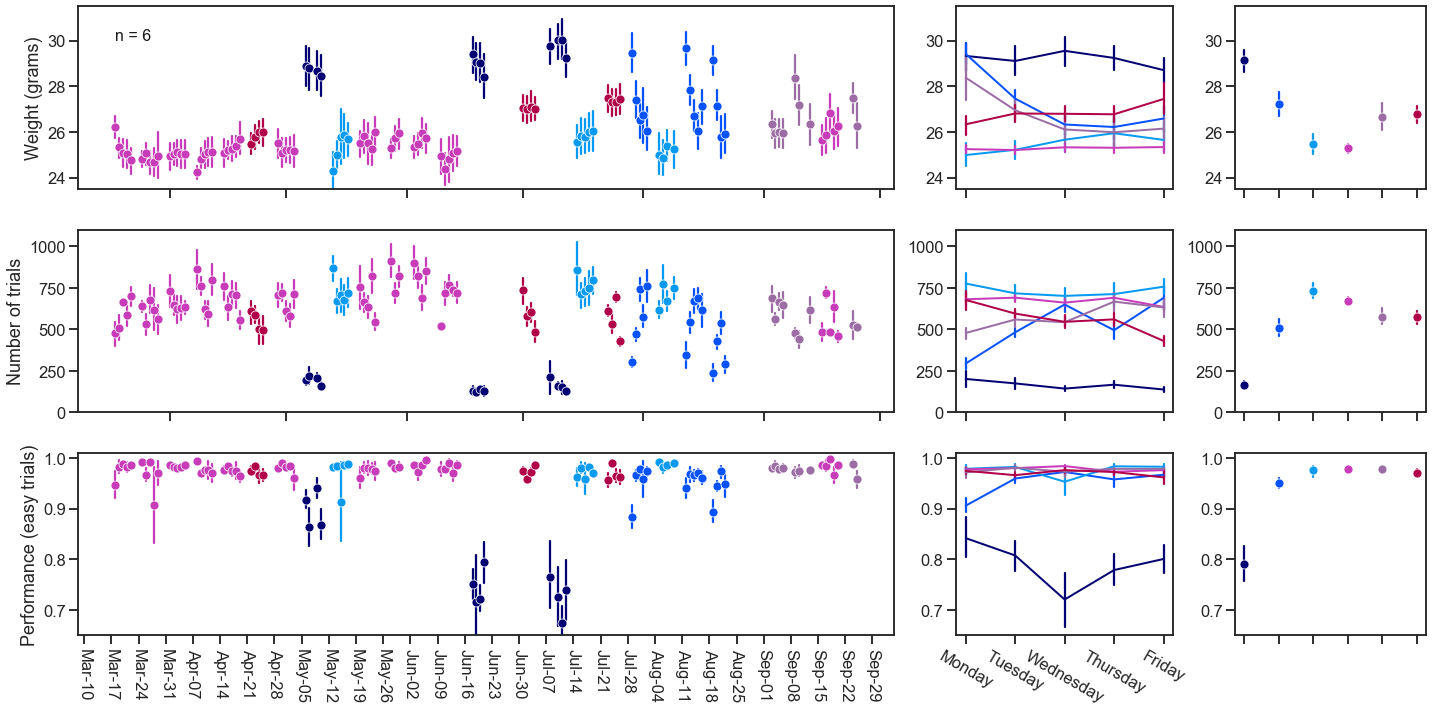

In [72]:
## NOW PLOT WITH SEABORN

f, ax = plt.subplots(ncols=3, nrows=3, 
                     gridspec_kw=dict(width_ratios=[3, 0.8, 0.7], height_ratios=[1,1,1]), figsize=(20, 10))
ylims_weight = [23.5, 31.5]
ylims_ntrials = [0, 1100]
ylims_performance = [0.65, 1.01]

sns.lineplot(x="session_date", y="avg_weight", err_style='bars', ci=68, hue="condition", marker='o', 
             linewidth=0, data=df, ax=ax[0,0], legend=False, hue_order=condition_order, palette=palette)
ax[0,0].set(ylabel="Weight (grams)", ylim=ylims_weight, xlabel="")
ax[0,0].tick_params(labelbottom=False)    
ax[0,0].text(df.session_date.min(), 30, 'n = 6', {'color':'k', 'fontsize':16})
sns.lineplot(x="session_date", y="n_trials", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=0, data=df, ax=ax[1,0], legend=False, hue_order=condition_order, palette=palette)
ax[1,0].set(ylabel="Number of trials", xlabel="", ylim=ylims_ntrials)
ax[1,0].tick_params(labelbottom=False)    
sns.lineplot(x="session_date", y="performance_easy", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=0, data=df, ax=ax[2,0], legend=False, hue_order=condition_order, palette=palette)
ax[2,0].set(ylabel="Performance (easy trials)", xlabel="", ylim=ylims_performance)

# set grid to show Mondays
fix_date_axis(ax[2,0])

## SECOND COLUMN
sns.lineplot(x="weekday", y="avg_weight", err_style='bars', ci=68, hue="condition",
             linewidth=2, data=df, ax=ax[0,1], legend=False, hue_order=condition_order, palette=palette)
ax[0,1].set(ylabel="", ylim=ylims_weight, xlabel="")
ax[0,1].tick_params(labelbottom=False)    
sns.lineplot(x="weekday", y="n_trials", err_style='bars', ci=68, hue="condition",
             linewidth=2, data=df, ax=ax[1,1], legend=False, hue_order=condition_order, palette=palette)
ax[1,1].set(ylabel="", ylim=ylims_ntrials, xlabel="")
ax[1,1].tick_params(labelbottom=False)    
sns.lineplot(x="weekday", y="performance_easy", err_style='bars', ci=68, hue="condition",
             linewidth=2, data=df, ax=ax[2,1], legend=False, hue_order=condition_order, palette=palette)
ax[2,1].set(ylabel="", xticks=[0,1,2,3,4], 
          xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], xlabel="", ylim=ylims_performance)

for item in ax[2,1].get_xticklabels():
    item.set_rotation(-30)
    
## Third columns

sns.lineplot(x="condition", y="avg_weight", err_style='bars', marker='o', ci=95, linewidth=2, hue_order=condition_order, palette=palette, hue="condition", data=df, ax=ax[0,2])
#sns.boxplot(x="condition", y="avg_weight", order=condition_order,data=df, fliersize=0, ax=ax[0,2], boxprops={'facecolor':'None'}, width=.3)
ax[0,2].set(ylabel="", xlabel="", ylim=ylims_weight)
ax[0,2].get_legend().remove()
ax[0,2].tick_params(labelbottom=False)    

sns.lineplot(x="condition", y="n_trials", err_style='bars',marker='o', ci=95, linewidth=2, hue_order=condition_order, palette=palette, hue="condition", data=df, ax=ax[1,2])
#sns.boxplot(x="condition", y="n_trials", order=condition_order, data=df, fliersize=0, ax=ax[1,2], boxprops={'facecolor':'None'}, width=.3)
ax[1,2].set(ylabel="", xlabel="", ylim=ylims_ntrials)
ax[1,2].get_legend().remove()
ax[1,2].tick_params(labelbottom=False)    
sns.lineplot(x="condition", y="performance_easy", err_style='bars', marker='o', ci=95, linewidth=2, hue_order=condition_order, palette=palette, hue="condition", data=df, ax=ax[2,2])
#sns.lineplot(x="condition", y="performance_easy", order=condition_order, data=df, fliersize=0, ax=ax[2,2], boxprops={'facecolor':'None'}, width=.3)
ax[2,2].set(ylabel="", xlabel="", ylim=ylims_performance)
ax[2,2].get_legend().remove()
ax[2,2].tick_params(labelbottom=False)    

# SAVE
f.tight_layout()
f.savefig(os.path.join(figpath, "citricacid_study2.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study2.png"), dpi=300)


# STUDY 2b. effects of CA in water vs Hydrogel
data collected by Valeria Aguillon and Anne Urai, CSHL
    

In [74]:
# FIND THE DATA WE NEED
# get session with date
session_with_date = behavior.TrialSet.proj('n_trials') \
    * (acquisition.Session.proj(session_date='DATE(session_start_time)') & 'session_date < "2018-12-31"') \
    * behavioral_analyses.PsychResults()
b = subj * session_with_date * avg_weight_date * total_water_date
df = pd.DataFrame(b.fetch(as_dict=True, order_by='session_start_time'))
df.head(n=10)


,subject_uuid,session_start_time,session_date,subject_nickname,sex,n_trials,performance,performance_easy,signed_contrasts,n_trials_stim,n_trials_stim_right,prob_choose_right,threshold,bias,lapse_low,lapse_high,avg_weight,total_water,watertype,adlib
0,3e97e1d3-2a0f-44e5-b63f-36196d78457a,2018-08-15 13:06:51,2018-08-15,IBL_34,M,175,0.165714,0.165714,"[-1.0, -0.5, 0.5, 1.0]","[6, 13, 94, 62]","[0, 2, 6, 6]","[0.0, 0.15384615384615385, 0.06382978723404255...",9.43275,-0.612869,1.052630e-01,0.923077,19.379999,0.787,Water,0
1,1fce4668-e99f-4e50-9f75-961842781a23,2018-08-15 15:12:01,2018-08-15,IBL_36,M,202,0.287129,0.287129,"[-1.0, -0.5, 0.5, 1.0]","[17, 15, 109, 61]","[4, 1, 13, 18]","[0.23529411764705882, 0.06666666666666667, 0.1...",4.33949,73.243300,1.276600e-01,0.704918,19.760000,0.824,Water,0
2,3e97e1d3-2a0f-44e5-b63f-36196d78457a,2018-08-16 13:38:47,2018-08-16,IBL_34,M,350,0.351429,0.351429,"[-1.0, -0.5, 0.5, 1.0]","[34, 39, 108, 169]","[5, 6, 27, 34]","[0.14705882352941177, 0.15384615384615385, 0.2...",15.96610,-35.054100,1.470590e-01,0.779783,19.330000,0.669,Water,0
3,1fce4668-e99f-4e50-9f75-961842781a23,2018-08-16 15:19:26,2018-08-16,IBL_36,M,184,0.206522,0.206522,"[-1.0, -0.5, 0.5, 1.0]","[8, 11, 70, 95]","[1, 1, 8, 13]","[0.125, 0.09090909090909091, 0.114285714285714...",100.00000,27.314800,9.522240e-02,0.861606,19.770000,0.814,Water,0
4,3e97e1d3-2a0f-44e5-b63f-36196d78457a,2018-08-17 11:45:43,2018-08-17,IBL_34,M,212,0.547170,0.547170,"[-1.0, -0.5, 0.5, 1.0]","[25, 51, 69, 67]","[1, 9, 24, 26]","[0.04, 0.17647058823529413, 0.3478260869565217...",85.94340,-34.675100,8.553520e-12,0.609596,19.420000,0.748,Water,0
5,1fce4668-e99f-4e50-9f75-961842781a23,2018-08-17 13:44:45,2018-08-17,IBL_36,M,363,0.440771,0.440771,"[-1.0, -0.5, 0.5, 1.0]","[84, 86, 71, 122]","[39, 42, 32, 39]","[0.4642857142857143, 0.4883720930232558, 0.450...",30.33720,72.416300,4.764710e-01,0.697604,19.860001,0.780,Water,0
6,3e97e1d3-2a0f-44e5-b63f-36196d78457a,2018-08-20 13:24:16,2018-08-20,IBL_34,M,600,0.565000,0.565000,"[-1.0, -0.5, 0.5, 1.0]","[120, 115, 188, 177]","[37, 34, 83, 92]","[0.30833333333333335, 0.2956521739130435, 0.44...",19.65060,45.008500,3.021280e-01,0.480218,19.740000,1.017,Water,0
7,1fce4668-e99f-4e50-9f75-961842781a23,2018-08-20 14:45:53,2018-08-20,IBL_36,M,730,0.527397,0.527397,"[-1.0, -0.5, 0.5, 1.0]","[146, 154, 190, 240]","[35, 65, 83, 102]","[0.23972602739726026, 0.42207792207792205, 0.4...",31.63540,-93.306500,1.217780e-01,0.569767,20.150000,1.155,Water,0
8,3e97e1d3-2a0f-44e5-b63f-36196d78457a,2018-08-21 14:15:26,2018-08-21,IBL_34,M,634,0.591483,0.591483,"[-1.0, -0.5, 0.5, 1.0]","[168, 159, 147, 160]","[79, 70, 93, 104]","[0.47023809523809523, 0.44025157232704404, 0.6...",15.96180,34.815700,4.556570e-01,0.350000,19.840000,1.440,Water,0
9,3e97e1d3-2a0f-44e5-b63f-36196d78457a,2018-08-21 14:57:40,2018-08-21,IBL_34,M,211,0.497630,0.497630,"[-1.0, -0.5, 0.5, 1.0]","[26, 35, 92, 58]","[1, 4, 27, 22]","[0.038461538461538464, 0.11428571428571428, 0....",100.00000,3.451080,1.503370e-02,0.597828,19.840000,1.440,Water,0
